In [1]:
import numpy as np
import pandas as pd 
import gurobipy as gp
from gurobipy import GRB
from bs4 import BeautifulSoup
import lxml

In [2]:
with open('NL4.xml', 'r') as f:
    data = f.read()

In [3]:
Bs_data = BeautifulSoup(data, "xml")

In [4]:
Bs_data

<?xml version="1.0" encoding="utf-8"?>
<Instance>
<MetaData>
<InstanceName>NL4</InstanceName>
<DataType>A</DataType>
<Contributor>Easton, Nemhauser, and Trick</Contributor>
<Date day="0" month="0" year="2001"/>
<Country/>
<Remarks>Based on National Hockey League</Remarks>
<Lowerbound infeasibility="0" objective="0"/>
</MetaData>
<Structure>
<Format leagueIds="0">
<numberRoundRobin>2</numberRoundRobin>
<compactness>C</compactness>
</Format>
<AdditionalGames/>
</Structure>
<ObjectiveFunction>
<Objective>TR</Objective>
</ObjectiveFunction>
<Data>
<Distances>
<distance dist="0" team1="0" team2="0"/>
<distance dist="745" team1="0" team2="1"/>
<distance dist="665" team1="0" team2="2"/>
<distance dist="929" team1="0" team2="3"/>
<distance dist="745" team1="1" team2="0"/>
<distance dist="0" team1="1" team2="1"/>
<distance dist="80" team1="1" team2="2"/>
<distance dist="337" team1="1" team2="3"/>
<distance dist="665" team1="2" team2="0"/>
<distance dist="80" team1="2" team2="1"/>
<distance dist

In [5]:
raw_distance_entries = Bs_data.find_all("distance")
distances = []
team1nrs = []
team2nrs = []
for e in raw_distance_entries:
    print(e)
    distances.append(e.get("dist"))
    team1nrs.append(e.get("team1"))
    team2nrs.append(e.get("team2"))

DF = pd.DataFrame(np.array([distances, team1nrs, team2nrs]).T, columns = ["distance", "team1", "team2"])

<distance dist="0" team1="0" team2="0"/>
<distance dist="745" team1="0" team2="1"/>
<distance dist="665" team1="0" team2="2"/>
<distance dist="929" team1="0" team2="3"/>
<distance dist="745" team1="1" team2="0"/>
<distance dist="0" team1="1" team2="1"/>
<distance dist="80" team1="1" team2="2"/>
<distance dist="337" team1="1" team2="3"/>
<distance dist="665" team1="2" team2="0"/>
<distance dist="80" team1="2" team2="1"/>
<distance dist="0" team1="2" team2="2"/>
<distance dist="380" team1="2" team2="3"/>
<distance dist="929" team1="3" team2="0"/>
<distance dist="337" team1="3" team2="1"/>
<distance dist="380" team1="3" team2="2"/>
<distance dist="0" team1="3" team2="3"/>


In [6]:
DF

,distance,team1,team2
0,0,0,0
1,745,0,1
2,665,0,2
3,929,0,3
4,745,1,0
5,0,1,1
6,80,1,2
7,337,1,3
8,665,2,0
9,80,2,1


In [7]:
raw_team_entries = Bs_data.find_all("team")
team_dict = {}
for e in raw_team_entries:
    team_dict[e.get("id")] = e.get("name")
team_dict

{'0': 'ATL', '1': 'NYM', '2': 'PHI', '3': 'MON'}

In [8]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph

In [9]:
arcs = list(DF[["team1", "team2"]].itertuples(index=False, name=None))

In [10]:
for i in range(DF.shape[0]):
    print(f"{DF["distance"][i]} - {DF["team1"][i]} - {DF["team2"][i]}")

0 - 0 - 0
745 - 0 - 1
665 - 0 - 2
929 - 0 - 3
745 - 1 - 0
0 - 1 - 1
80 - 1 - 2
337 - 1 - 3
665 - 2 - 0
80 - 2 - 1
0 - 2 - 2
380 - 2 - 3
929 - 3 - 0
337 - 3 - 1
380 - 3 - 2
0 - 3 - 3


{('0', '0', 0): Text(0.3102604913009266, 0.26042605533899343, '0'),
 ('0', '1', 0): Text(0.4869386039942598, -0.34948851480513277, '745'),
 ('0', '2', 0): Text(-0.02855713994055742, 0.5411503450478865, '665'),
 ('0', '3', 0): Text(-0.1481220891693844, -0.10936625612329476, '929'),
 ('1', '0', 0): Text(0.4869357293461942, -0.3494814893873829, '745'),
 ('1', '1', 0): Text(0.6636138420395274, -0.6031422305257801, '0'),
 ('1', '2', 0): Text(0.14811759801321378, 0.10936976306350643, '80'),
 ('1', '3', 0): Text(0.028552974231055184, -0.5411482116076671, '337'),
 ('2', '0', 0): Text(-0.02855599596081404, 0.5411487957882422, '665'),
 ('2', '1', 0): Text(0.14812261682401584, 0.10936109190784893, '80'),
 ('2', '2', 0): Text(-0.3673736272022979, 1.1781269145028637, '0'),
 ('2', '3', 0): Text(-0.48693472975465624, 0.34949826073793355, '380'),
 ('3', '0', 0): Text(-0.148118125667846, -0.1093645988480666, '929'),
 ('3', '1', 0): Text(0.028560161670315387, -0.5411509292284679, '337'),
 ('3', '2', 0):

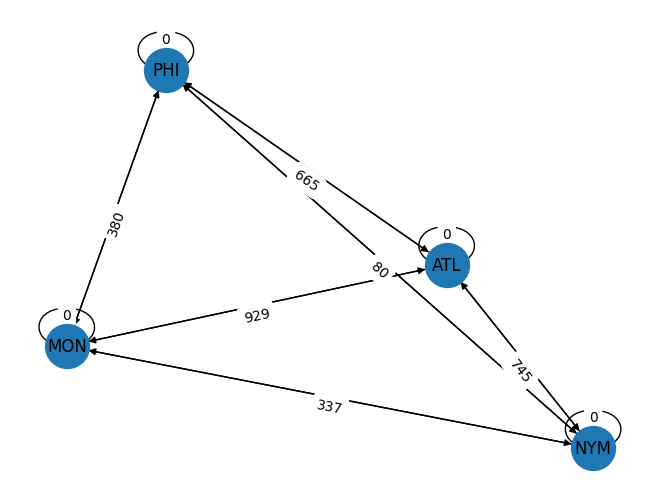

In [11]:
G = nx.MultiDiGraph()
for entry in team_dict:
    G.add_node(entry)

for i in range(DF.shape[0]):
    distance = int(DF["distance"][i])
    length = 0
    if int(distance) > 0:
        length = 1/int(distance)
    team1 = DF["team1"][i]
    team2 = DF["team2"][i]
    G.add_edge(team1, team2, weight=distance, length=length)

pos = nx.spring_layout(G)

nx.draw(G, pos=pos, with_labels=True, labels=team_dict, node_size = 1000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), verticalalignment="top")

#### Column Generation

- Implement regular CG
- Try to see if getting integer solutions is possible when fixing probabilities that are almost 1.